# Juliaによる混合整数計画法（線形計画法）

最近~~仕事さぼって~~Juliaでいろんな実験をするのにはまっています。今日はJuliaと外部APIを使って混合整数計画法をやってみます。

私は線形計画法のプロでもなんでもないので，線形計画法については[こちら（PDF直リンク）](http://web.tuat.ac.jp/~miya/fujie_ORSJ.pdf)が参考になると思います。[Rによる項目反応理論](https://shop.ohmsha.co.jp/shopdetail/000000003874/)の第15章にも取り上げられている内容です。

線形計画法とは特定の制約条件(Constraints)下で目的関数(Objective)を最小or最大とするような変数の組み合わせを求めるもので，

$$
\begin{alignat}{2}
 &\text{minimize}   & \quad  c^\top x  &        \label{eqn:P_Obj}     \\
 &\text{subject to} & \quad  Ax        &\geq b  \label{eqn:P_Con-Eq}  \\
 &                  & \quad  x         &\geq 0. \label{eqn:P_Con-Non} 
\end{alignat}
$$

という感じで定式化されます。単純な線形計画法は中学か高校の数学でも習いますが，今回はこれに整数条件が加わった整数計画法および混合整数計画法を使って，「理想的な自動テスト編成」をやります。

### 項目反応理論とテスト情報量

項目反応理論（IRT)ではテスト項目やテスト自体の測定精度の指標として**テスト情報量 (Test Information, TIF)** が定義されています。TIFはICC（項目特性曲線）を $ P(\theta) = logistic(\alpha(\theta-\beta)) $ とおき，あるテストに含まれるテスト項目に関する添え字を $j = 1, 2, ... J$とすると，以下のように求められます。
$$
TIF(\theta) = \sum_j^J \alpha_j^2(p(\theta)(1-P(\theta))
$$

TIFは受検者の潜在能力値 $\theta$ の関数として定義され，テスト情報量が大きいところほど，測定精度が高いと解釈されます（ちなみにテスト情報量自体は統計学におけるいわゆる**フィッシャー情報量**の定義から導かれます。対数尤度関数の二階偏微分の負の期待値ですね）。

ここで，あるテスト項目プール（IRTのパラメタ推定済みの項目をたくさん保持しておく場所，項目バンクとも）から，一定の条件でテスト冊子を編成するケースを考えます。たとえば100個の問題の中から，出題する対象に最適な測定精度のテスト冊子を構成するのです。

最適化の制約や方向には様々な方法があるのですが，ここではテスト情報量の**下限値制約**を満たすなかで，最もテスト項目の**情報量を節約**しつつ，**重複項目のないテスト冊子**を作ることを目的にしたいと思います。下限値制約は一定以上の測定精度を保持するため，情報量の節約は項目バンクの暴露（IRTでは項目が受検者に対策されてしまうと，推定が正しくおこなえなくなる恐れがある）を防ぐためです。情報量の節約は無駄な項目の出題を避けることもできるので，効率よく受検者の能力を推定することにも役に立ちます。

### Solver

基本的にはJuliaの`JuMP`pkgを使います。しかし最適化のsolverに関してはいくつか選択肢があり，非商用から商用まで様々カバーしています。

ここでは，変な牛さんみたいなアイコンが特徴の[GLPK](http://www.gnu.org/software/glpk/)を使います。

In [ ]:
## DO NOT RUN ## 
# using Pkg
# Pkg.add("JuMP"); Pkg.add("GLPK")

In [5]:
using JuMP, GLPK
using Random, Distributions, StatsFuns # 乱数生成と情報量計算に使う
using Plots

# test infromation function
function tif(θ, α, β)
    I = zeros(length(θ))
    for m in 1:length(θ)
        for j in 1:length(α)
            p = logistic(α[j]*(θ[m]-β[j]))
            I[m] += α[j]^2 * p * (1-p)
        end
    end
    return I
end

tif (generic function with 1 method)

### 自動テスト編成　その1

まず手始めに，90個の項目をもつ項目プールから，30個のテスト冊子を取り出すことを考えます。最低限度のテスト情報量を保持したテスト冊子を目指します。目的となるテスト情報量は項目バンク全体のテスト情報量を，取り出すテスト冊子の項目数に合わせて除したものとします。つまり，もとの項目バンクとなるべく同じテスト情報関数の形状になるように，テスト冊子を構成するのです。詳細な制約条件はまた後ほど記述します。

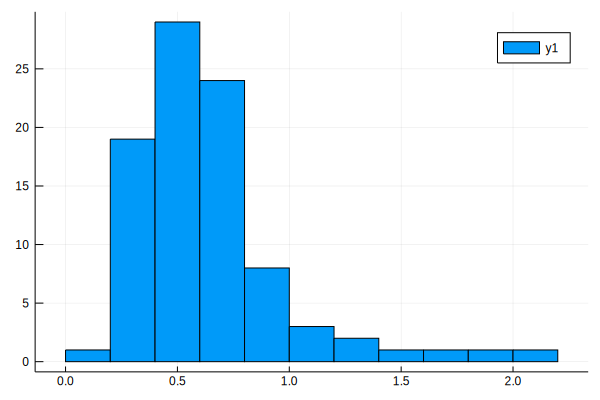

In [34]:
Random.seed!(1234)
α = rand(LogNormal(-0.5, 0.5), 90) # 項目識別力
histogram(α)

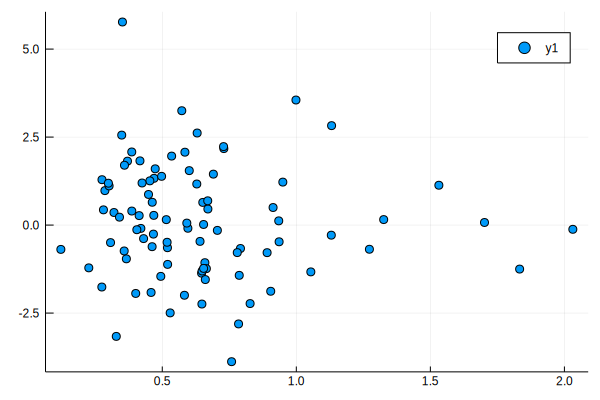

In [35]:
β = rand(Normal(0, 1.5), 90) # 項目困難度
scatter(α, β)

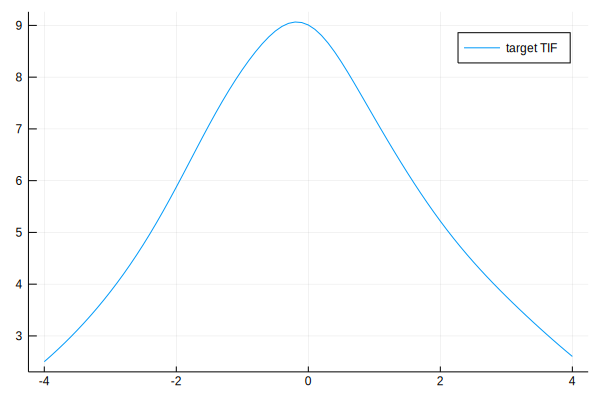

In [48]:
target_θ = [-2:1:2;]
target_TIF = tif(target_θ, α, β) * 30/90
IIF = [tif(target_θ[i], α[j], β[j])[1] for i in 1:5, j in 1:90]
plot([-4:0.1:4;], tif([-4:0.1:4;], α, β), label = "target TIF")

最適化方向に対しての情報量の下限値は適当な点数でOKです。このtarget_TIFが変な形（きつい三角形）だったりすると最適化が難しく，失敗することがあります。

なお，最適化のための目的関数ですが，項目バンクのテスト情報量をなるべく節約する方向に設定すれば良いので，**テスト冊子に含まれる識別力の和**とすればよいです。もちろん無制約に最小化すれば，ただ識別力の小さい項目をとってくるだけですので，ここに下限値制約が加わるわけです。

続いて，モデルを組み立てていきます。必要になるのは
1. 目的関数
2. 決定変数
3. 制約条件
の3つです。

`JuMP`の文法については[公式ドキュメント](http://www.juliaopt.org/JuMP.jl/v0.19.2/)やsolverへのインターフェイスを提供する関数の[ドキュメント](http://www.juliaopt.org/MathOptInterface.jl/v0.6.1/apimanual.html#Sets-and-Constraints-1)が参考になります。日本語だと[この記事](https://myenigma.hatenablog.com/entry/2017/10/28/141805)も参考になります。

In [38]:
mod1 = Model(with_optimizer(GLPK.Optimizer))
@variable(mod1, 0 <= x[1:90] <= 1, Int) # 決定変数
@objective(mod1, Min, α' * x) # 目的変数

0.9358253619513699 x[1] + 0.3864039678519896 x[2] + 0.47367238044788285 x[3] + 0.3861778953382992 x[4] + 0.9344479579417156 x[5] + 1.832972103656246 x[6] + 0.7916836815603108 x[7] + 0.5294758637815399 x[8] + 0.7797103676313849 x[9] + 0.46837228882930027 x[10] + 0.458291117488107 x[11] + 0.6007082574478093 x[12] + 0.6466385585208436 x[13] + 1.5317202938948689 x[14] + 0.40096476799044956 x[15] + 0.6408550768129122 x[16] + 0.5349468568503699 x[17] + 0.7296845347024683 x[18] + 0.628800134841628 x[19] + 0.28601393983292045 x[20] + 1.3258902462243427 x[21] + 0.3016862576970978 x[22] + 1.0541649316862556 x[23] + 0.3487622026564447 x[24] + 0.12176286868804573 x[25] + 0.5844948721208734 x[26] + 0.6540887775920585 x[27] + 0.8910445348777064 x[28] + 0.5194024376210554 x[29] + 0.4487212333196793 x[30] + 0.3198714428156127 x[31] + 0.9986594771333122 x[32] + 0.7055421634995673 x[33] + 0.5955779518373137 x[34] + 0.6511515482808155 x[35] + 0.7871285738761749 x[36] + 0.9496838982854913 x[37] + 0.469181

本来決定変数は0か1の二値です（プールの項目がテスト冊子に含まれるのならば1，そうでないならば0）。`@variavle`の三つ目の引数で整数制約を課しています。本当なら`Int`ではなく`Bin`でもいけそうなのですが，私の環境では無理でした。

当然ですが，目的変数に決定変数が入るわけですから，決定変数は目的変数よりも先に宣言しておく必要があります。

出力されたベクトルが，目的関数の数式表現です。

In [41]:
@constraint(mod1, fill(1, 90)'x == 30) # 項目数は30個
@constraint(mod1, [fill(1,50);fill(0,40)]'x == 18) # 前半から18項目
@constraint(mod1, [fill(0,50);fill(1,40)]'x == 12) # 後半から12項目
@constraint(mod1, target_TIF[1]+.1 >= IIF[1,:]'x >= target_TIF[1]-0) # テスト情報量の制約条件1~5
@constraint(mod1, target_TIF[2]+.1 >= IIF[2,:]'x >= target_TIF[2]-0)
@constraint(mod1, target_TIF[3]+.1 >= IIF[3,:]'x >= target_TIF[3]-0)
@constraint(mod1, target_TIF[4]+.1 >= IIF[4,:]'x >= target_TIF[4]-0)
@constraint(mod1, target_TIF[5]+.1 >= IIF[5,:]'x >= target_TIF[5]-0)
@constraint(mod1, 1 >= [fill(0,29);1;fill(0,29);1;fill(0, 29);1]'x >= 0) # 敵対項目

x[30] + x[60] + x[90] in [0.0, 1.0]

制約条件は以下の通りです。

- テスト項目数は30とする。
- 項目バンクの前半と後半を異なる領域の問題（たとえば基礎と応用）とみなして，前半から18項目，後半から12項目採用する。
- 5点のテスト情報量において，目的情報量よりも+0.1の範囲の誤差に抑える。
- 敵対項目（一緒に含めてはいけない項目）が3項目（30，60，90）あるとする。

for loopを使えばベタうちしなくても良いと思います。

それでは最適化を実行します。

In [42]:
@time optimize!(mod1)

  0.209900 seconds (23.15 k allocations: 1.387 MiB)


コンパイル済みならば瞬殺です。結果がうまくいっているかは`termination_status()`で確認できます

In [43]:
termination_status(mod1) # OPTIMAL::TerminationStatusCode = 1 ならいちおうOK

OPTIMAL::TerminationStatusCode = 1

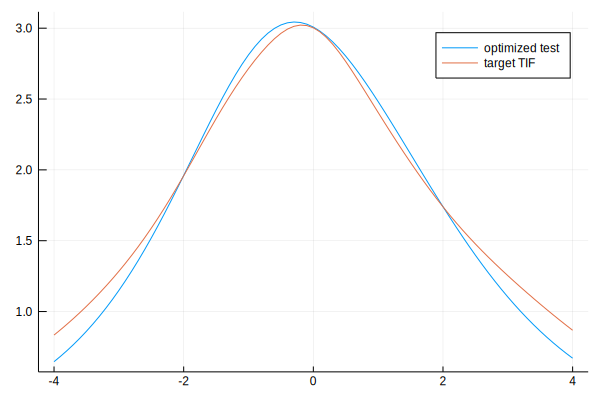

In [47]:
get_item = value.(x)
plot([-4:0.1:4;], tif([-4:0.1:4;], α[isone.(get_item)], β[isone.(get_item)]), label = "optimized test")
plot!([-4:0.1:4;], tif([-4:0.1:4;], α, β) * 30/90,label = "target TIF")

最適化で指定した点の位置(-2, -1, 0, 1, 2)では良い感じです。端っこの方の領域でズレが生じていますが，どのみにここら辺の帯域の受検者は今回のテストの想定する対象外なので，問題ないです。

### 重複を含まずに，複数のテストフォームを取り出す

次はもっと複雑な条件にします。1つの項目プールから，3つのテストフォームを同時に編成することを考えます。もちろん先ほどと同様にテスト情報量に関する制約があります。さらにフォーム間で項目が重複してはいけないものとします。

さっそくモデルを組み立てていきます。

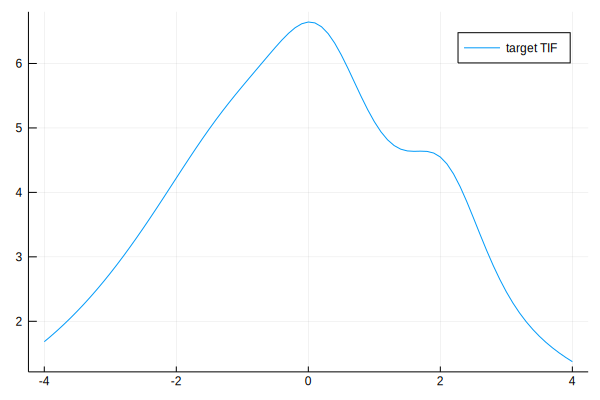

In [52]:
# 項目パラメタの生成
Random.seed!(1234)
α2 = rand(LogNormal(-0.5, 0.6), 60)
β2 = rand(Normal(0, 1.5), 60)
# 制約のためのIIF, TIFの計算
IIF3 = [tif(target_θ[i], α2[j], β2[j])[1] for i in 1:5, j in 1:60]
target_TIF3 = tif(target_θ, α2, β2) * 10/60
plot([-4:0.1:4;], tif([-4:0.1:4;], α2, β2), label = "target TIF")

同時複数テスト編成になると，組み合わせの数が一気に跳ね上がり，計算時間が途方もないことになります。そのため今回は全体的に小規模なテストを想定しています。

In [78]:
# create model
mod2 = Model(with_optimizer(GLPK.Optimizer))
# declare variables
@variable(mod2, 0 <= F1[1:60*3] <= 1, Int) # Test From 1 to 3
@variable(mod2, 0 <= F2[1:60*3] <= 1, Int)
@variable(mod2, 0 <= F3[1:60*3] <= 1, Int)
# objective functions
@objective(mod2, Min, repeat(α2, inner = 1, outer = 3)' * F1)
@objective(mod2, Min, repeat(α2, inner = 1, outer = 3)' * F2)
@objective(mod2, Min, repeat(α2, inner = 1, outer = 3)' * F3)
# impose constraints
# item size in each test forms
@constraint(mod2, [fill(1,60); fill(0,120)             ]'F1 == 10) # item size
@constraint(mod2, [fill(0,60); fill(1,60); fill(0,60)]'F2 == 10)
@constraint(mod2, [fill(0,120);              fill(1, 60)]'F3 == 10)
# item domain
@constraint(mod2, [fill(1,35);fill(0,25);fill(0,120)]'F1 == 7) # 前半から18項目
@constraint(mod2, [fill(0,35);fill(1,25);fill(0,120)]'F1 == 3) # 後半から12項目
@constraint(mod2, [fill(0,60);fill(1,35);fill(0,25);fill(0,60)]'F2 == 7)
@constraint(mod2, [fill(0,60);fill(0,35);fill(1,25);fill(0,60)]'F2 == 3)
@constraint(mod2, [fill(0,120);fill(1,35);fill(0,25)]'F3 == 7)
@constraint(mod2, [fill(0,120);fill(0,35);fill(1,25)]'F3 == 3)
# TIF constraints
@constraint(mod2, target_TIF3[1]+.1 >= [IIF3[1,:];fill(0,120)]'F1 >= target_TIF3[1]-.1)
@constraint(mod2, target_TIF3[2]+.1 >= [IIF3[2,:];fill(0,120)]'F1 >= target_TIF3[2]-.1)
@constraint(mod2, target_TIF3[3]+.1 >= [IIF3[3,:];fill(0,120)]'F1 >= target_TIF3[3]-.1)
@constraint(mod2, target_TIF3[4]+.1 >= [IIF3[4,:];fill(0,120)]'F1 >= target_TIF3[4]-.1)
@constraint(mod2, target_TIF3[5]+.1 >= [IIF3[5,:];fill(0,120)]'F1 >= target_TIF3[5]-.1)

@constraint(mod2, target_TIF3[1]+.1 >= [fill(0,60);IIF3[1,:];fill(0,60)]'F2 >= target_TIF3[1]-.1)
@constraint(mod2, target_TIF3[2]+.1 >= [fill(0,60);IIF3[2,:];fill(0,60)]'F2 >= target_TIF3[2]-.1)
@constraint(mod2, target_TIF3[3]+.1 >= [fill(0,60);IIF3[3,:];fill(0,60)]'F2 >= target_TIF3[3]-.1)
@constraint(mod2, target_TIF3[4]+.1 >= [fill(0,60);IIF3[4,:];fill(0,60)]'F2 >= target_TIF3[4]-.1)
@constraint(mod2, target_TIF3[5]+.1 >= [fill(0,60);IIF3[5,:];fill(0,60)]'F2 >= target_TIF3[5]-.1)

@constraint(mod2, target_TIF3[1]+.1 >= [fill(0,120);IIF3[1,:]]'F3 >= target_TIF3[1]-.1)
@constraint(mod2, target_TIF3[2]+.1 >= [fill(0,120);IIF3[2,:]]'F3 >= target_TIF3[2]-.1)
@constraint(mod2, target_TIF3[4]+.1 >= [fill(0,120);IIF3[4,:]]'F3 >= target_TIF3[4]-.1)
@constraint(mod2, target_TIF3[3]+.1 >= [fill(0,120);IIF3[3,:]]'F3 >= target_TIF3[3]-.1)
@constraint(mod2, target_TIF3[5]+.1 >= [fill(0,120);IIF3[5,:]]'F3 >= target_TIF3[5]-.1)

# between test forms
for j in 1:60
    @constraint(mod2, 1 >= [F1[j] + F2[j+60] + F3[j+120]][1] >= 0)
end

最後のloopは冊子間に重複項目を許さない制約についてです。loopにしてやらないと`Range constraint is not supported for GenericAffExpr{Float64,VariableRef}`で怒られます。

それでは，最適化を実行します。

In [79]:
@time optimize!(mod2)

 27.991487 seconds (263.30 k allocations: 34.654 MiB, 0.05% gc time)


In [80]:
termination_status(mod2) # OPTIMAL::TerminationStatusCode = 1 ならいちおうOK

OPTIMAL::TerminationStatusCode = 1

In [91]:
get_F1 = value.(F1)
get_F2 = value.(F2)
get_F3 = value.(F3)

[([1:60; 1:60; 1:60][isone.(get_F1)])';([1:60; 1:60; 1:60][isone.(get_F2)])'; ([1:60; 1:60; 1:60][isone.(get_F3)])']

3×10 Array{Int64,2}:
 1   8  29  32  33  34  35  41  55  60
 3  10  11  12  26  28  30  37  48  59
 4   7   9  16  19  20  25  36  47  56

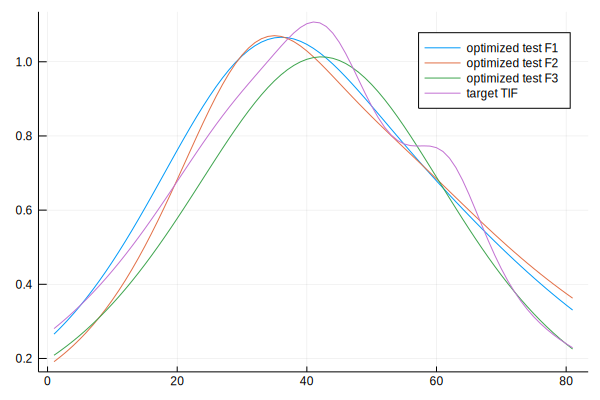

In [95]:
plot(tif([-4:0.1:4;], [α2 α2 α2][isone.(get_F1)], [β2 β2 β2][isone.(get_F1)]), label = "optimized test F1")
plot!(tif([-4:0.1:4;], [α2 α2 α2][isone.(get_F2)], [β2 β2 β2][isone.(get_F2)]), label = "optimized test F2")
plot!(tif([-4:0.1:4;], [α2 α2 α2][isone.(get_F3)], [β2 β2 β2][isone.(get_F3)]), label = "optimized test F3")
plot!(tif([-4:0.1:4;], α2, β2) * 10/60, label = "target TIF") # SUCCESS...?